In [1]:
# Calculate the Reflux Coefficient from TEF
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import TEF_Variables as tef

In [7]:
def reflux(Qsg, hs, xi):
    #/Volumes/Extreme SSD/MITgcm outputs
    #../../Model_outputs
#     State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
#     Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/grid_' + str(format(hs,'03d')) + '.nc')

    # Confine to the range of fjord
#     state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
#     grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))
    State = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/Qsg' + str(format(Qsg,'03d')) + 'n/state_' + str(format(hs,'03d')) + '.nc')
    Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/Qsg' + str(format(Qsg,'03d')) + 'n/grid_' + str(format(hs,'03d')) + '.nc')
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(10,21))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
    Qin = np.empty(len(xi))
    Qout = np.empty(len(xi))
    Sin = np.empty(len(xi))
    Sout = np.empty(len(xi))
    t0 = 89 # 274
    
    for i in range(len(xi)):
    
        tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi[i],23,testing=False)

        qin1, qout1, sin1, sout1 = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
#         Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
#         Qout[i] = qout1[t0:].mean()
#         Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
#         Sout[i] = sout1[t0:].mean()
        Qin[i] = qin1[10:21].mean() # Time averaging from 1+t0 hour
        Qout[i] = qout1[10:21].mean()
        Sin[i] = sin1[10:21].mean() # Time averaging from 1+t0 hour
        Sout[i] = sout1[10:21].mean()
        
    a002 = (Sin[0]/Sout[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    a001 = (Qin[0]-Qin[1]) / Qin[0]    
    a11 = (Sout[1]/Sin[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])    
    a01 = (Sout[1]/Sout[0])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    a10 = (Sin[0]/Sin[1])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    
    #a00 = -(Qout[0]/Qin[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    #a11 = -(Qin[1]/Qout[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])
    #a01 = (Qin[1]/Qin[0])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    #a10 = (Qout[0]/Qout[1])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    q0 = Qin[0]
    q1 = -Qout[-1]
    Q0 = -Qout[0]
    Q1 = Qin[-1]
    f0 = Sin[0]*q0
    f1 = Sout[-1]*q1
    F0 = Sout[0]*Q0
    F1 = Sin[-1]*Q1
    
    A = np.array([[q1, q0, 0, 0], [f1, f0, 0, 0], [0, 0, q1, q0], [0, 0, f1, f0]])
    B = np.array([Q1, F1, Q0, F0])
    X = np.linalg.solve(A,B) # a11, a01, a10, a00
    
    #return a00,q q0, q1, Q0
    #return a001, a002, X[-1]
    return X[0],X[-1],q1,q0,Q1,Q0

In [8]:
qsg = 500
hs = np.array([1,2,3,4,5,6])
# xrange = np.array([47,97])
xrange = np.array([120,235])

eflx = np.empty(len(hs))
rflx = np.empty(len(hs))
q1 = np.empty(len(hs))
q0 = np.empty(len(hs))
Q1 = np.empty(len(hs))
Q0 = np.empty(len(hs))

for j in range(len(hs)):
    
    eflx[j], rflx[j], q1[j], q0[j], Q1[j], Q0[j] = reflux(qsg,hs[j],xrange)
    


  time 0 out of 11
  time 0 out of 11


/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice.
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.


  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11
  time 0 out of 11


In [10]:
#eflx, rflx, Q0 - q1, q0- Q1, Q0
Q0[:-1]-q1[:-1]

array([nan, nan, nan, nan, nan])

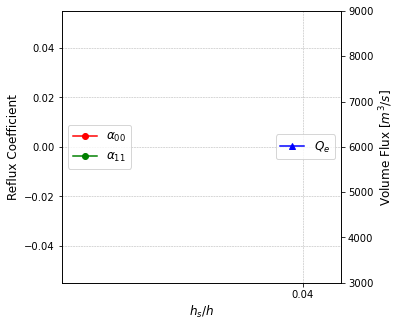

In [9]:
# fig0,ax0 = plt.subplots(figsize=(10,7))

# ax0.plot(hsr,rflx1,'o-',label='downward only')
# ax0.plot(hsr,rflx3,'o-',label='two-way')

# ax0.legend(loc='best', fontsize=15)
# ax0.set_ylabel(r'reflux coefficient $\alpha_{00}$',size = 20)
# ax0.set_xlabel(r'$h_s/h$', size = 20)
# ax0.grid(linestyle='--', linewidth='0.5')
hsr = np.array([0.04,0.06,0.08,0.10,0.12,1.0])

fig0, ax1 = plt.subplots(figsize=(5,5))
plt.grid(linestyle = '--', linewidth = 0.5)
ax1.plot(hsr[:-1],rflx[:-1],'o-r',label=r'$\alpha_{00}$')
eflx[eflx<0] = 0
ax1.plot(hsr[:-1],eflx[:-1],'o-g',label=r'$\alpha_{11}$')
ax1.legend(loc='center left', fontsize=12)
ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
ax1.set_xlabel(r"$h_s/h$",fontsize=12)
#ax1.set_ylim([0, .7])
ax1.set_ylabel(r"Reflux Coefficient",fontsize=12)

ax2=ax1.twinx()
ax2.plot(hsr[:-1],Q0[:-1]-q1[:-1],'^-b',label=r'$Q_e$')
ax2.legend(loc='right', fontsize=12)
# ax2.set_ylim([0, 2800])
ax2.set_ylim([3000, 9000])
ax2.set_ylabel(r"Volume Flux $[m^3/s]$",fontsize=12)


plt.show()

In [ ]:
def vol_temp(Qsg, hs, xi):
    #/Volumes/Extreme SSD/MITgcm outputs
    State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/grid_' + str(format(hs,'03d')) + '.nc')
    # Confine to the range of fjord
    state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    rA = np.broadcast_to(grid.rA.data[np.newaxis, np.newaxis, :, :], U.shape)
    CV = rA * drF * HFacC

    
    t0 = 89 # 274
    da = DA[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    cv = CV[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    s = state.S.data[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    temp = state.Temp.data[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    u = U[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    uma = np.ma.MaskedArray(u, mask=topo)
    tma = np.ma.MaskedArray(temp, mask=topo)
    
    #HFacC = grid.HFacC.data
    #CV = np.broadcast_to(grid.drF.data[:, np.newaxis, np.newaxis], HFacC.shape) * np.broadcast_to(grid.rA.data[np.newaxis, :, :], HFacC.shape) * HFacC # Cell Volume
    
    Tv1 = np.empty(uma.shape[1])
    Tv2 = np.empty(uma.shape[1])
    Vol1 = np.empty(uma.shape[1])
    Vol2 = np.empty(uma.shape[1])
    Tvol1 = np.empty(uma.shape[1])
    Tvol2 = np.empty(uma.shape[1])
    
    for i in range(uma.shape[1]):
            
        if any(uma[:,i]<0)==False:
            pass
            
        else:
            l = np.where(uma[:,i] < 0)[-1][0]    
            Tv1[i] = np.sum(tma[:l,i]*da[:l,i]*uma[:l,i]) / np.sum(da[:l,i]*uma[:l,i])
            Tv2[i] = np.sum(tma[l:,i]*da[l:,i]*uma[l:,i]) / np.sum(da[l:,i]*uma[l:,i])
            Vol1[i] = cv[:l,i].sum()
            Vol2[i] = cv[l:,i].sum()
            Tvol1[i] = np.sum(tma[:l,i]*cv[:l,i])
            Tvol2[i] = np.sum(tma[l:,i]*cv[l:,i])
            
        Tf = Tv1[:-1].mean()
        Ts = Tv2[:-1].mean()
        #Tf = Tvol1[:-1].sum()/Vol1[:-1].sum()
        #Ts = Tvol2[:-1].sum()/Vol2[:-1].sum()
        Ts_in = Tv2[-1]
            
    return Tf, Ts, Ts_in
    #return Tv1, Tv2

In [ ]:
qsg = 500
hs = np.array([1,2,3,4,5])
xrange1 = np.array([5,47]) # 3~47 47~97
xrange2 = np.array([47,97]) # 3~47 47~97

rflx1 = np.empty(len(hs))
alp111 = np.empty(len(hs))
alp001 = np.empty(len(hs))
Qin01 = np.empty(len(hs))
Qin11 = np.empty(len(hs))
Qout01 = np.empty(len(hs))
Ts1 = np.empty(len(hs))
Tf1 = np.empty(len(hs))
Ts_in1 = np.empty(len(hs))


rflx2 = np.empty(len(hs))
alp112 = np.empty(len(hs))
alp002 = np.empty(len(hs))
Qin02 = np.empty(len(hs))
Qin12 = np.empty(len(hs))
Qout02 = np.empty(len(hs))
Ts2 = np.empty(len(hs))
Tf2 = np.empty(len(hs))
Ts_in2 = np.empty(len(hs))



for j in range(len(hs)):
    
    alp111[j], alp001[j], Qin11[j], Qin01[j], Qout11, Qout01[j] = reflux(qsg,hs[j],xrange1)
    
    Tf1[j], Ts1[j], Ts_in1[j] = vol_temp(qsg,hs[j],xrange1)
    
    alp112[j], alp002[j], Qin12[j], Qin02[j], Qout12, Qout02[j] = reflux(qsg,hs[j],xrange2)
    
    Tf2[j], Ts2[j], Ts_in2[j] = vol_temp(qsg,hs[j],xrange2)

In [ ]:
actual = np.concatenate((Ts1, Ts2))
actual

In [ ]:
#Tse = (Ts_in*Qin1 + Tf*Qin0*alp00) / Qout0
Tse1 = (Ts_in1*Qin11*(1-alp111) + Tf1*Qin01*alp001) / Qout01
Tse2 = (Ts_in2*Qin12*(1-alp112) + Tf2*Qin02*alp002) / Qout02


actual = np.concatenate((Ts1, Ts2))
predict = np.concatenate((Tse1, Tse2))
 
corr_matrix = np.corrcoef(actual, predict)
corr = corr_matrix[0,1]
R_sq = corr**2
print(R_sq)

In [ ]:

#fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig1, ax1 = plt.subplots(figsize=(5,5))


plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$T_s^{est}\;[^\circ C]$', size=12)
plt.ylabel(r'$T_s^{obs}\;[^\circ C]$', size=12)


for j in range(len(hs)):

    ax1.plot(Tse2[j], Ts2[j], marker='o', alpha=.7, ms=3*(j+3), color='orange', markeredgecolor='k')
    ax1.plot(Tse1[j], Ts1[j], marker='^', alpha=.7, ms=3*(j+3), color='blue', markeredgecolor='k')
    
ax1.set(xlim=(6, 9.5), ylim=(6, 9.5))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c="red")
loc_mark1 = [6.5, 9.3]
plt.plot(loc_mark1[0],loc_mark1[1], marker='o', alpha=.7, ms=12, color='orange', markeredgecolor='k')
plt.text(loc_mark1[0]+0.15, loc_mark1[1]-0.06, r'Fjord Interior', fontsize=12)
loc_mark2 = [6.5, 9]
plt.plot(loc_mark2[0],loc_mark2[1], marker='^', alpha=.7, ms=12, color='blue', markeredgecolor='k')
plt.text(loc_mark2[0]+0.15, loc_mark2[1]-0.06, r'Sill', fontsize=12)

plt.text(7.8, 6.5, r'$r^2=$'+str(format(R_sq,'1.2f')), fontsize=12)

plt.grid(linestyle = '--', linewidth = 0.5)
#ax1.set_title(r'Interior', loc='center', size=15)
#ax1.set_title(r'Fjord', loc='center', size=15)
# ax1.set_aspect('equal', 'box')
# ax2.set(xlim=(6, 9.5), ylim=(6, 9.5))
# ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
# ax2.set_title(r'Sill', loc='center', size=15)
# ax2.set_aspect('equal', 'box')
plt.show()

In [ ]:
#Tse, Ts
alp00, alp11

In [ ]:
hsr = hs / 150

fig3, ax3 =plt.subplots(figsize=(10,7))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$h_s/h$', size=20)
#plt.ylabel(r'$\alpha_{00}$', size=20)
plt.ylabel(r'$T_f\;(^\circ C)$', size=20)
ax3.plot(hsr,Tf,'o-r',lw=2)
#ax3.plot(hsr,alp00,'o-b',lw=2)
#ax3.set(ylim=(0, .6))
ax3.set_title(r'Interior', loc='center', size=15)

In [ ]:
## Compare the along fjord distribution of Ts from Model and Efflux/Reflux Estimate

Qsg = 700
Xi = np.arange(2,6)
sill = np.array([9,12])

state = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_ShelfTracer/state_' + str(format(sill[0],'03d')) + '.nc')
xdist = state.X.data

Tf, Ts = vol_temp(Qsg,sill[1],np.array([Xi[0],Xi[-1]+1]))

Tse = np.empty(len(Xi)-1)
for k in range(len(Xi)-1):
    xrange = np.array([Xi[0]+k,Xi[0]+k+2])
    alp11, alp00, Qin1, Qin0, Qout0 = reflux(Qsg,sill[1],xrange)
    Tse[k] = (Ts[k+1]*Qin1*(1-alp11) + Tf[k]*Qin0*alp00) / Qout0
    



In [ ]:
Ts,Tse

In [ ]:
xx = np.array([3,5])
a11, a00, q1, q0, Q0 = reflux(700,9,xx)
a11, a00, q1, q0, Q0

In [ ]:
fig2,ax2 = plt.subplots(figsize=(12,6))

ax2.plot(xdist[Xi[0]:Xi[-1]],Ts[:-1],'r-',label='Observation')
ax2.plot(xdist[Xi[0]:Xi[-1]],Tse,'b-',label='Estimate')
ax2.axvline(x=5800, color='k',lw=2,linestyle='--')
#ax1.plot(time,Tr1_rlx2,'-',label='Relax-1800s')

ax2.legend(loc='best', fontsize=15)
ax2.set_ylabel(r'$T_s$ ($^\circ$C)',size = 20)
ax2.set_xlabel(r'Distance from glacier (m)', size = 20)
ax2.grid(linestyle='--', linewidth='0.5')
ax2.set_title(r'$h_s=$'+str(sill[1])+'m', loc='center', size=15)
ax2.set(xlim=(4000, 6000), ylim=(6, 10))

In [ ]:
correlation_matrix = np.corrcoef(Tse, Ts)
r_squared = correlation_matrix[0,1]**2
r_squared

In [ ]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/TEF/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig0.savefig(fig_path + '/reflux.png', dpi=200, bbox_inches='tight')
fig1.savefig(fig_path + '/Tf.png', dpi=200, bbox_inches='tight')

In [ ]:
fig_path ="/home/1959/Jupyter_Figs/Qsg500n/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig0.savefig(fig_path + '/reflux.png', dpi=200, bbox_inches='tight')    